<a href="https://colab.research.google.com/github/HanhengHe/BigDataCourseProj/blob/main/bigdataproj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
RUNLARGE = True
NUMCLASS= 50 if RUNLARGE else 10

In [ ]:
# GET FILE

from google.colab import drive
import zipfile

drive.mount('/content/drive/', force_remount=False)

filePath = "/content/drive/MyDrive/Dataset_large" if RUNLARGE else "/content/drive/MyDrive/Dataset_small/data1.zip"

with zipfile.ZipFile(filePath,"r") as zip_ref:
    zip_ref.extractall("targetdir")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models

In [ ]:
# LOADING TRAINING DATA

lsTrainLabel = []
lsTrainData = []

trainingPath = "/content/targetdir/dataset2" if RUNLARGE else "/content/targetdir/data1"

with open(trainingPath + "/train_label.txt") as f:
  for line in f.readlines():
    expression = line.split(' ')
    lsTrainLabel.append(int(expression[1]))
    dataRGB = np.load(trainingPath + "/train/" + expression[0]).transpose((2,0,1))
    lsTrainData.append(dataRGB)
    # turn training data into grayscale data
    # lsData.append((dataRGB[:, :, 0] + dataRGB[:, :, 1] + dataRGB[:, :, 2]) / 3)

INITER = torch.zeros(2, lsTrainData[0].shape[0], lsTrainData[0].shape[1], lsTrainData[0].shape[2])

print("Number of traning data: {0}".format(len(lsTrainLabel)), end='\n')
print("Shape of traning data: {0}".format(lsTrainData[0].shape), end='\n')

Number of traning data: 64163
Shape of traning data: (3, 224, 224)


In [ ]:
# LOAD TEST DATA

lsTestLabel = []
lsTestData = []

testingPath = "/content/targetdir/dataset2" if RUNLARGE else "/content/targetdir/data1"


with open(testingPath + "/test_label.txt") as f:
  for line in f.readlines():
    expression = line.split(' ')
    lsTestLabel.append(int(expression[1]))
    dataRGB = np.load(testingPath + "/test/" + expression[0]).transpose((2,0,1))
    lsTestData.append(dataRGB)
    # turn training data into grayscale data
    # lsData.append((dataRGB[:, :, 0] + dataRGB[:, :, 1] + dataRGB[:, :, 2]) / 3)

print("Number of testing data: {0}".format(len(lsTestLabel)), end='\n')
print("Shape of testing data: {0}".format(lsTestData[0].shape), end='\n')

Number of testing data: 2500
Shape of testing data: (3, 224, 224)


In [ ]:
from torchvision.models.resnet import ResNet50_Weights

class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.model = models.resnet18()

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        return x


class ResNet34(nn.Module):
    def __init__(self):
        super(ResNet34, self).__init__()
        self.model = models.resnet34()

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        return x


class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        self.model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        return x


class ResNet101(nn.Module):
    def __init__(self):
        super(ResNet101, self).__init__()
        self.model = models.resnet101()

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        return x


class ResNet152(nn.Module):
    def __init__(self):
        super(ResNet152, self).__init__()
        self.model = models.resnet152()

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        return x

In [ ]:
from torchvision.models.resnet import ResNeXt50_32X4D_Weights, ResNeXt101_32X8D_Weights

class ResNeXt50(nn.Module):
    def __init__(self):
        super(ResNeXt50, self).__init__()
        self.model = models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        return x

class ResNeXt101_32(nn.Module):
    def __init__(self):
        super(ResNeXt101_32, self).__init__()
        self.model = models.resnext101_32x8d(weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        return x

class ResNeXt101_64(nn.Module):
    def __init__(self):
        super(ResNeXt101_64, self).__init__()
        self.model = models.resnext101_64x4d()

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        return x

In [ ]:
from torchvision.models.densenet import DenseNet121_Weights, DenseNet161_Weights

class DenseNet121(nn.Module):
    def __init__(self):
        super(DenseNet121, self).__init__()
        self.model = models.densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)

    def forward(self, x):
         x = self.model(x)
         x = x.view(x.size(0), -1)
         return x

class DenseNet161(nn.Module):
    def __init__(self):
        super(DenseNet161, self).__init__()
        self.model = models.densenet161(weights=DenseNet161_Weights.IMAGENET1K_V1)

    def forward(self, x):
         x = self.model(x)
         x = x.view(x.size(0), -1)
         return x

class DenseNet169(nn.Module):
    def __init__(self):
        super(DenseNet169, self).__init__()
        self.model = models.densenet169()

    def forward(self, x):
         x = self.model(x)
         x = x.view(x.size(0), -1)
         return x

class DenseNet201(nn.Module):
    def __init__(self):
        super(DenseNet201, self).__init__()
        self.model = models.densenet201()

    def forward(self, x):
         x = self.model(x)
         x = x.view(x.size(0), -1)
         return x

In [ ]:
from torchvision.models.efficientnet import EfficientNet_V2_S_Weights

class EfficientNetV2(nn.Module):
    def __init__(self):
        super(EfficientNetV2, self).__init__()
        self.model = models.efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1)

    def forward(self, x):
         x = self.model(x)
         x = x.view(x.size(0), -1)
         return x

class ConvNeXt_base(nn.Module):
    def __init__(self):
        super(ConvNeXt_base, self).__init__()
        self.model = models.convnext_base()

    def forward(self, x):
         x = self.model(x)
         x = x.view(x.size(0), -1)
         return x

class ConvNeXt_large(nn.Module):
    def __init__(self):
        super(ConvNeXt_large, self).__init__()
        self.model = models.convnext_large()

    def forward(self, x):
         x = self.model(x)
         x = x.view(x.size(0), -1)
         return x

class MaxVit(nn.Module):
    def __init__(self):
        super(MaxVit, self).__init__()
        self.model = models.maxvit()

    def forward(self, x):
         x = self.model(x)
         x = x.view(x.size(0), -1)
         return x

In [ ]:
network_dict = {"ResNet18": ResNet18,
                "ResNet34": ResNet34,
                "ResNet50": ResNet50,
                "ResNet101": ResNet101,
                "ResNet152": ResNet152,

                "DenseNet121": DenseNet121,
                "DenseNet161": DenseNet161,
                "DenseNet169": DenseNet169,
                "DenseNet201": DenseNet201,

                "ResNeXt50": ResNeXt50,
                "ResNeXt101_32": ResNeXt101_32,
                "ResNeXt101_64": ResNeXt101_64,

                "EfficientNetV2": EfficientNetV2,

                "ConvNeXt_base": ConvNeXt_base,
                "ConvNeXt_large": ConvNeXt_large}

In [ ]:
# NETWORK DEFINE MODULE

torch.cuda._initialized = True

class Network(nn.Module):
    
    def __init__(self, initer: torch.Tensor, num_classes: int, kernalType: str):
        
        super(Network, self).__init__()
        self.backbone = network_dict[kernalType]()
        self.fc = nn.Linear(self.backbone(initer).shape[1], num_classes)
        
    def forward(self, x):
        
        x = self.backbone(x)
        x = self.fc(x)
        # x = F.softmax(x, dim=1)  # note this when use ce
        return x 

In [ ]:
CPU = torch.device("cpu")
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else CPU
# DEVICE = CPU
print("DEVICE = %s" % (DEVICE))

DEVICE = cuda:0


In [ ]:
# TRAINING MODULE 

import math
from torch.optim.lr_scheduler import StepLR
import time
import os.path
from os import path
import matplotlib.pyplot as plt

class LogHelper:
    def __init__(self):
        self.strLog = ""
    
    def PrintAndLog(self, strMsg: str, show=True, end="\n"):
        self.strLog += strMsg
        self.strLog += end
        if show:
            print(strMsg, end=end)

def Processing(KERNALTYPE, 
               Epochs = 50, 
               MINLOSS = 1e-5, 
               MINIBATCH_SIZE = 128, 
               LEARNING_RATE = 0.001, 
               lr_diff = 1e-5, 
               lrChangeFq = -1,
               gammaScheduler = 0.8,
               outputFrequence = 10
               ):

    lsTrainLoss = []

    logHelper = LogHelper() 

    bChangeLr = lrChangeFq != -1
    torch.cuda.empty_cache()
    model = Network(INITER, NUMCLASS, KERNALTYPE).to(DEVICE)

    trainLabels = np.array(lsTrainLabel)
    trainSet = np.array(lsTrainData)
  
    trainSet = torch.from_numpy(trainSet).float()

    criterion = nn.CrossEntropyLoss() # ce
    # criterion = nn.NLLLoss()  # nll
    trainLabels = torch.from_numpy(trainLabels)    # nll
    torch_dataset = Data.TensorDataset(trainSet, trainLabels.long())    # nll

    # criterion = nn.MSELoss()  # mse
    # trainLabels = torch.nn.functional.one_hot(torch.from_numpy(trainLabels), num_classes=NUMCLASS)  # mse
    # torch_dataset = Data.TensorDataset(trainSet, trainLabels.float())  # mse


    # put the dataset into DataLoader
    loader = Data.DataLoader(
        dataset=torch_dataset,
        batch_size=MINIBATCH_SIZE,
        shuffle=True,
        num_workers=0
    )

    nSteps = math.ceil(trainLabels.shape[0] / MINIBATCH_SIZE)

    # OPTIMIZER
    # optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = StepLR(optimizer, step_size=lrChangeFq if bChangeLr else Epochs, gamma=gammaScheduler)

    logHelper.PrintAndLog("\n\nKERBALTYPE: " + KERNALTYPE)
    logHelper.PrintAndLog("INIT LEARNING RATE={0}; EPOCH={1}; CHGFR={2}; GAMMA={3}".format(LEARNING_RATE, Epochs, lrChangeFq, gammaScheduler))
    logHelper.PrintAndLog("TRAINING...")

    model.train()
    lastLoss = 0
    for epoch in range(Epochs):

        curLoss = 0

        for step, (batch_x, batch_y) in enumerate(loader):
            optimizer.zero_grad()        
            output = model(batch_x.to(DEVICE))
            loss = criterion(output, batch_y.to(DEVICE))  # ce
            loss.backward()
            optimizer.step()

            curLoss += loss.item() / nSteps

        lsTrainLoss.append(curLoss)

        if bChangeLr:
            scheduler.step()
            LEARNING_RATE = optimizer.param_groups[0]['lr']
        
        lrMsg = " lr = {0:.5}".format(LEARNING_RATE) if bChangeLr else ""
        curMsg = " Epoch {0}, general loss: {1}".format(epoch+1, curLoss) + lrMsg

        logHelper.PrintAndLog(curMsg, show=((epoch == 0) or ((epoch + 1) % outputFrequence == 0)))

        if curLoss <= MINLOSS:
            logHelper.PrintAndLog(" Terminated with low loss. Epoch {0}, general loss: {1}".format(epoch+1, curLoss) + lrMsg)
            break
        
        if abs(lastLoss - curLoss) <= lr_diff:
            logHelper.PrintAndLog(" Terminated with unchanged loss. Epoch {0}, general loss: {1}".format(epoch+1, curLoss) + lrMsg)
            break
        
        lastLoss = curLoss

    # TEST MODULE

    testLabels = np.array(lsTestLabel)
    testSet = np.array(lsTestData)

    testSet = torch.from_numpy(testSet).float()
    testLabels = torch.from_numpy(testLabels).to(DEVICE)

    model.eval()
    logHelper.PrintAndLog("TESTING...")

    test_loss = 0
    correct = 0

    # first transform the data to dataset can be processed by torch
    # torch_dataset = Data.TensorDataset(testSet, testLabels.long())  # nll

    testLabelsOneHot = torch.nn.functional.one_hot(testLabels, num_classes=NUMCLASS)  # mse
    torch_dataset = Data.TensorDataset(testSet, testLabelsOneHot.float())  # mse

    # put the dataset into DataLoader
    loader = Data.DataLoader(
        dataset=torch_dataset,
        batch_size=MINIBATCH_SIZE,
        shuffle=False,
        num_workers=0
    )

    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(loader):
            output = model(batch_x.to(DEVICE))
            test_loss += criterion(output, batch_y.to(DEVICE)).item()  # mse
            predict = output.max(1, keepdim=True)[1]  # find the prediction
            labels = batch_y.max(1, keepdim=True)[1]
            correct += predict.eq(labels.view_as(predict)).sum().item()

    testSize = testLabels.shape[0]
    test_loss /= testSize
    logHelper.PrintAndLog(" Test: Average loss:%s, Accuracy: %s/%s (%s)"
        % (test_loss, correct, testSize, correct / testSize))
    
    struct_time = time.localtime() # get struct_time
    strTime = time.strftime("%m-%d-%Y_%H:%M:%S", struct_time)

    fileName = KERNALTYPE + ("_L_" if RUNLARGE else "_S_") + strTime
    filePath = '/content/drive/MyDrive/BigDataProjLog/{0}/'.format(KERNALTYPE)

    print(fileName)

    if not os.path.exists(filePath):
        os.makedirs(filePath)

    with open(filePath + fileName + '.log', 'w') as f:
        f.write(logHelper.strLog)
    
    # plot
    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.xticks([])
    plt.plot(list(range(0,len(lsTrainLoss))), lsTrainLoss)
    plt.title(fileName)
    plt.savefig(filePath + fileName + '.png')
    plt.show()

In [ ]:
# test
"""for key in network_dict:
    Processing(key)"""

'for key in network_dict:\n    Processing(key)'

In [ ]:
"""
"ResNet18", "ResNet34", "ResNet50", "ResNet101", "ResNet152", 
"DenseNet121", "DenseNet161", "DenseNet169", "DenseNet201", 
"ResNeXt50", "ResNeXt101_32", "ResNeXt101_64", "EfficientNetV2", 
"ConvNeXt_base", "ConvNeXt_large"
"""

'\n"ResNet18", "ResNet34", "ResNet50", "ResNet101", "ResNet152", \n"DenseNet121", "DenseNet161", "DenseNet169", "DenseNet201", \n"ResNeXt50", "ResNeXt101_32", "ResNeXt101_64", "EfficientNetV2", \n"ConvNeXt_base", "ConvNeXt_large"\n'



KERBALTYPE: ResNet18
INIT LEARNING RATE=0.001; EPOCH=50; CHGFR=5; GAMMA=0.8
TRAINING...
 Epoch 1, general loss: 3.049883026525794 lr = 0.001
 Epoch 10, general loss: 0.4642707956620902 lr = 0.00064
 Epoch 20, general loss: 0.0589306911154914 lr = 0.0004096
 Epoch 30, general loss: 0.022022968131688924 lr = 0.00026214
 Epoch 40, general loss: 0.005732250792709553 lr = 0.00016777
 Epoch 50, general loss: 0.005420171517195938 lr = 0.00010737
TESTING...
 Test: Average loss:0.031064705181121827, Accuracy: 1554/2500 (0.6216)
ResNet18_L_03-26-2023_01:15:17


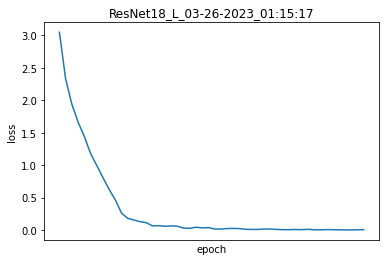

In [ ]:
Processing("ResNet18", lrChangeFq=5, outputFrequence=10)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]



KERBALTYPE: ResNet50
INIT LEARNING RATE=0.001; EPOCH=50; CHGFR=5; GAMMA=0.8
TRAINING...
 Epoch 1, general loss: 1.8858980697939607 lr = 0.001
 Epoch 10, general loss: 0.095104393545553 lr = 0.00064
 Epoch 20, general loss: 0.02822645960386799 lr = 0.0004096
 Epoch 30, general loss: 0.011727025914992688 lr = 0.00026214
 Epoch 40, general loss: 0.005178017308247061 lr = 0.00016777
 Epoch 50, general loss: 0.0018385330654400519 lr = 0.00010737
TESTING...
 Test: Average loss:0.014098177027702332, Accuracy: 1966/2500 (0.7864)
ResNet50_L_03-26-2023_02:31:06


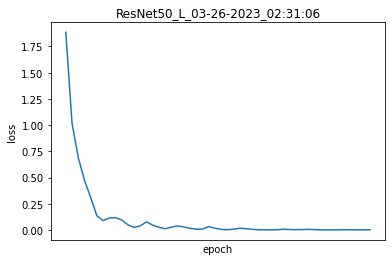

In [ ]:
Processing("ResNet50", lrChangeFq=5, outputFrequence=10)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]



KERBALTYPE: DenseNet121
INIT LEARNING RATE=0.001; EPOCH=50; CHGFR=5; GAMMA=0.8
TRAINING...
 Epoch 1, general loss: 1.885629969051637 lr = 0.001
 Epoch 10, general loss: 0.22416236203356812 lr = 0.00064
 Epoch 20, general loss: 0.05850234979056789 lr = 0.0004096
 Epoch 30, general loss: 0.02068930279721057 lr = 0.00026214
 Epoch 40, general loss: 0.011133094273348715 lr = 0.00016777
 Epoch 50, general loss: 0.0017617968720787572 lr = 0.00010737
TESTING...
 Test: Average loss:0.013185688948631287, Accuracy: 2047/2500 (0.8188)
DenseNet121_L_03-26-2023_04:17:37


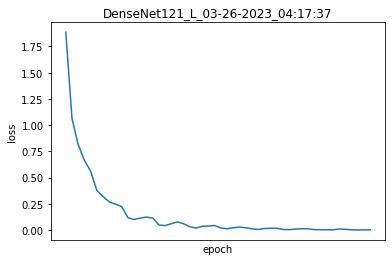

In [ ]:
Processing("DenseNet121", lrChangeFq=5, outputFrequence=10)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]



KERBALTYPE: DenseNet161
INIT LEARNING RATE=0.001; EPOCH=50; CHGFR=5; GAMMA=0.8
TRAINING...
 Epoch 1, general loss: 2.6571432660775347 lr = 0.001
 Epoch 10, general loss: 0.2188209413190881 lr = 0.00064
 Epoch 20, general loss: 0.045509009540871385 lr = 0.0004096
 Epoch 30, general loss: 0.025974005403575025 lr = 0.00026214
 Epoch 40, general loss: 0.006897210505257134 lr = 0.00016777
 Epoch 50, general loss: 0.002184904843582524 lr = 0.00010737
TESTING...
 Test: Average loss:0.015837464475631714, Accuracy: 1993/2500 (0.7972)
DenseNet161_L_03-26-2023_07:47:52


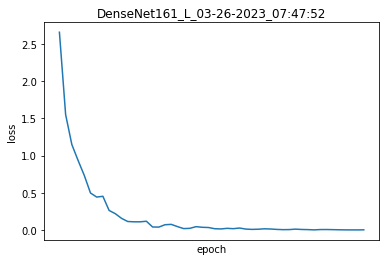

In [ ]:
Processing("DenseNet161", lrChangeFq=5, outputFrequence=10)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]



KERBALTYPE: ResNeXt50
INIT LEARNING RATE=0.001; EPOCH=50; CHGFR=5; GAMMA=0.8
TRAINING...
 Epoch 1, general loss: 1.5033824797645503 lr = 0.001
 Epoch 10, general loss: 0.08337954221760849 lr = 0.00064
 Epoch 20, general loss: 0.017619037619425276 lr = 0.0004096
 Epoch 30, general loss: 0.0085428326278544 lr = 0.00026214
 Epoch 40, general loss: 0.005452183014508722 lr = 0.00016777
 Epoch 50, general loss: 6.399475612587735e-05 lr = 0.00010737
 Terminated with unchanged loss. Epoch 50, general loss: 6.399475612587735e-05 lr = 0.00010737
TESTING...
 Test: Average loss:0.010482123041152954, Accuracy: 2086/2500 (0.8344)
ResNeXt50_L_03-26-2023_09:22:12


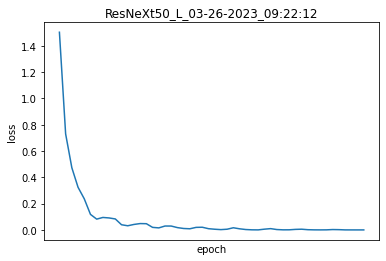

In [ ]:
Processing("ResNeXt50", lrChangeFq=5, outputFrequence=10)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


  0%|          | 0.00/340M [00:00<?, ?B/s]



KERBALTYPE: ResNeXt101_32
INIT LEARNING RATE=0.001; EPOCH=50; CHGFR=5; GAMMA=0.8
TRAINING...
 Epoch 1, general loss: 2.760568313627127 lr = 0.001
 Epoch 10, general loss: 0.16653226931909654 lr = 0.00064
 Epoch 20, general loss: 0.0390188706862746 lr = 0.0004096
 Epoch 30, general loss: 0.013807048633614868 lr = 0.00026214
 Epoch 40, general loss: 0.003019755100300912 lr = 0.00016777
 Epoch 50, general loss: 0.006066614208245221 lr = 0.00010737
TESTING...
 Test: Average loss:0.015542185544967651, Accuracy: 1927/2500 (0.7708)
ResNeXt101_32_L_03-26-2023_12:53:35


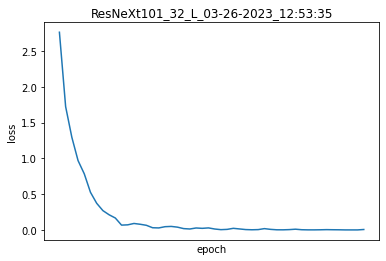

In [ ]:
Processing("ResNeXt101_32", lrChangeFq=5, outputFrequence=10)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


  0%|          | 0.00/82.7M [00:00<?, ?B/s]



KERBALTYPE: EfficientNetV2
INIT LEARNING RATE=0.001; EPOCH=50; CHGFR=5; GAMMA=0.8
TRAINING...
 Epoch 1, general loss: 1.5995445030618933 lr = 0.001
 Epoch 10, general loss: 0.14008342318118086 lr = 0.00064
 Epoch 20, general loss: 0.049864723144907946 lr = 0.0004096
 Epoch 30, general loss: 0.021383349479621217 lr = 0.00026214
 Epoch 40, general loss: 0.008707441862212133 lr = 0.00016777
 Epoch 50, general loss: 0.003737840051680467 lr = 0.00010737
TESTING...
 Test: Average loss:0.009177489423751831, Accuracy: 2128/2500 (0.8512)
EfficientNetV2_L_03-26-2023_14:49:46


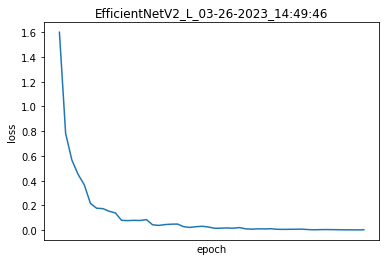

In [ ]:
Processing("EfficientNetV2", lrChangeFq=5, outputFrequence=10)

In [ ]:
Processing("ConvNeXt_base", outputFrequence=1)



KERBALTYPE: ConvNeXt_base
INIT LEARNING RATE=0.001; EPOCH=50; CHGFR=-1; GAMMA=0.8
TRAINING...
 Epoch 1, general loss: 3.8600555202400577
 Epoch 2, general loss: 3.483746445986379
 Epoch 3, general loss: 3.127415487965737
 Epoch 4, general loss: 2.835519679988997
 Epoch 5, general loss: 2.561437944492021
 Epoch 6, general loss: 2.300681722591598
 Epoch 7, general loss: 2.0872093709816504
 Epoch 8, general loss: 1.8881111218634812
 Epoch 9, general loss: 1.7170867542346644
 Epoch 10, general loss: 1.5477168182452843
 Epoch 11, general loss: 1.386884357231071
 Epoch 12, general loss: 1.2286781908506406
 Epoch 13, general loss: 1.0716165067902588
 Epoch 14, general loss: 0.9192721696488891
 Epoch 15, general loss: 0.7675672483990393
 Epoch 16, general loss: 0.634984286123537
 Epoch 17, general loss: 0.5121824077638495
 Epoch 18, general loss: 0.426261580649363
 Epoch 19, general loss: 0.35416386380376114
 Epoch 20, general loss: 0.3027987035355007
 Epoch 21, general loss: 0.2588774448045

In [ ]:
Processing("ConvNeXt_large", outputFrequence=1)

In [ ]:
from torchsummary import summary
model = Network(INITER, NUMCLASS, "Vit").to(DEVICE)
summary(model, (3, 224, 224))